In [1]:
import numpy as np

import mne
from mne.datasets import sample

# getting some data ready
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'

In [2]:
from mne.preprocessing import create_ecg_epochs, create_eog_epochs

In [25]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)



Opening raw data file /Users/dengeman/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


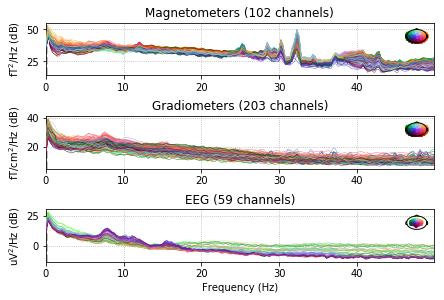

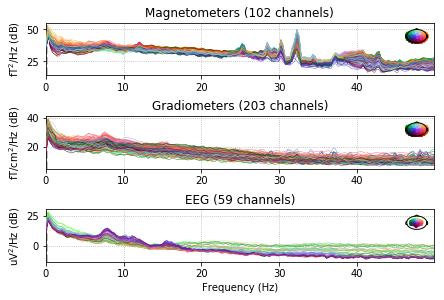

In [8]:
%matplotlib inline

raw.plot_psd(tmax=np.inf, fmax=50)

In [10]:
epochs_eog = create_eog_epochs(raw)

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 8192 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 8192 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 46 events and 601 original time points ...
0 bad epochs dropped


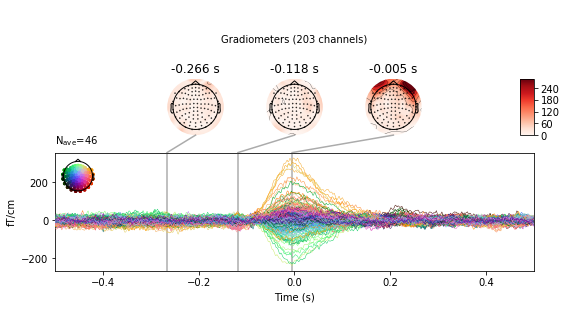

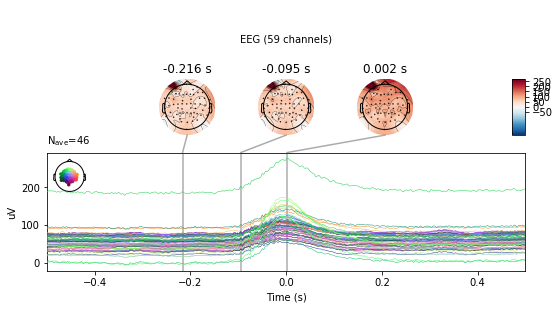

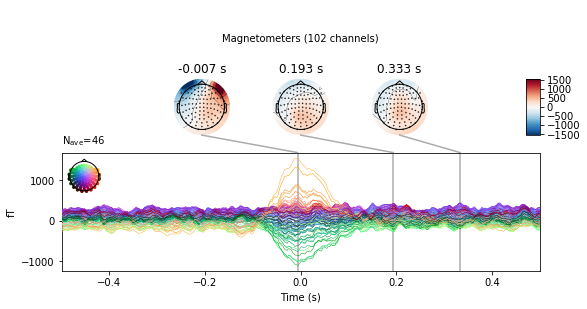

[<Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>]

In [11]:
epochs_eog.average().plot_joint()

# Question: how do we get the ECG when there is no channel?

We average the magnetometer signals.

In [14]:
x_mag = (raw.copy()
            .crop(tmin=0, tmax=10)
            .pick_types(meg='mag')
            .get_data()
            .mean(axis=0))

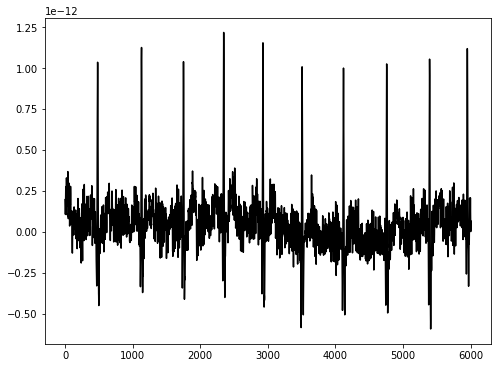

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
plt.plot(x_mag, color='black')
fig.show()

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz
Filter length of 8192 samples (13.639 sec) selected
Filter length of 8192 samples (13.639 sec) selected
Number of ECG events detected : 283 (average pulse 61 / min.)
283 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 283 events and 601 original time points ...
0 bad epochs dropped


In [26]:
raw.filter(l_freq=1, h_freq=None)
ecg_epochs = create_ecg_epochs(raw)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1983 samples (3.302 sec) selected
Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz
Filter length of 8192 samples (13.639 sec) selected
Filter length of 8192 samples (13.639 sec) selected
Number of ECG events detected : 283 (average pulse 61 / min.)
283 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 283 events and 601 original time points ...
0 bad epochs dropped


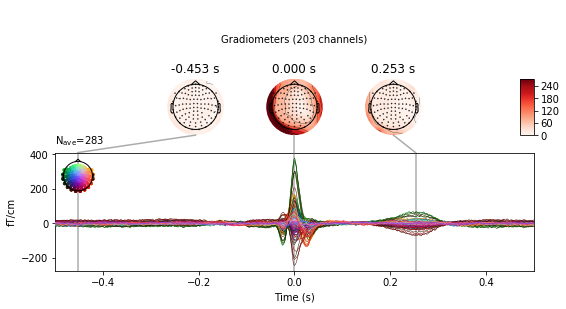

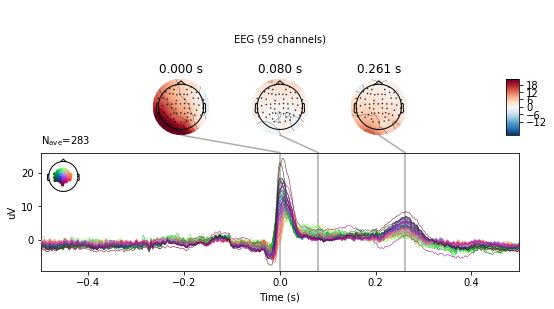

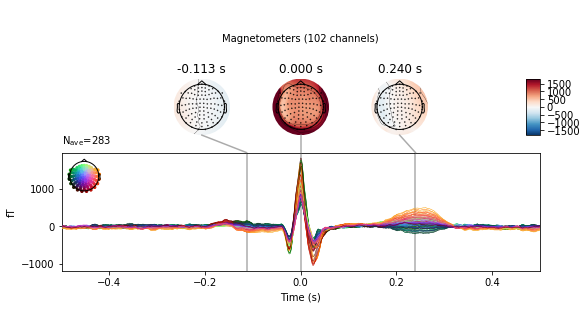

In [27]:
%matplotlib inline


ecg_epochs.average().plot_joint()

plt.show()

In [28]:
events = mne.find_events(raw)

event_id = {
    "aud/left": 1,
    "aud/right": 2,
    "vis/left": 3,
    "vis/right": 4
}

tmin = -0.2
tmax = 0.5
baseline = (None, 0)

epochs = mne.Epochs(raw=raw, events=events, event_id=event_id,
                    tmin=tmin, tmax=tmax, baseline=baseline,
                    reject=None)

320 events found
Event IDs: [ 1  2  3  4  5 32]
289 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated


In [31]:
reject = {'eog': 250e-6}
epochs_rej = mne.Epochs(
    raw=raw, events=events, event_id=event_id,
    tmin=tmin, tmax=tmax, baseline=baseline,
    reject=reject, preload=True)

289 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 289 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
11 bad epochs dropped


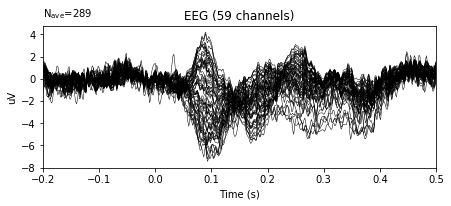

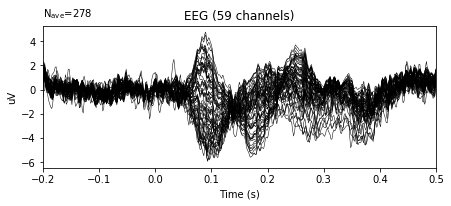

In [37]:
epochs.average().pick_types(meg=False, eeg=True).plot();
epochs_rej.average().pick_types(meg=False, eeg=True).plot();

In [33]:
evoked = epochs.average()

# Look at peak-peak amplitude distributions


1. Retrieve the EOG and EEG data from epochs
2. use np.ptp to compute peak-peak amplitude ranges in each trial
3. plot an overall histogram using all ptp values (in case of EEG you have multiple channels, checkout np.ravel)
    - hint: plt.hist hin
    - hint2: checkout log option
4. make separate plots for a few different channels (you can randomly select those)


In [39]:
picks_eog = mne.pick_types(
    epochs.info, meg=False, eeg=False, eog=True)

x_eog = epochs.get_data()[:, picks_eog]

Loading data for 289 events and 421 original time points ...
0 bad epochs dropped


In [49]:
ptp_eog = np.ptp(x_eog, axis=-1)[:, 0]

ptp_eog *= 1e6

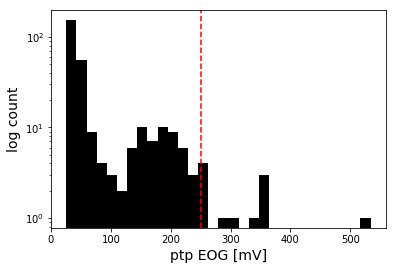

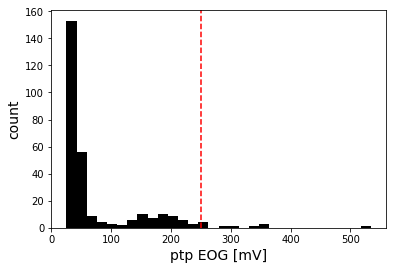

In [63]:
# import matplotlib.pyplot as plt
plt.figure()
plt.hist(ptp_eog, color='black', log=True, bins=30)
plt.ylabel('log count', fontdict={'size': 14})
plt.xlabel('ptp EOG [mV]', fontdict={'size': 14})
plt.axvline(250, color='red', linestyle='--')

plt.figure()
plt.hist(ptp_eog, color='black', log=False, bins=30)
plt.ylabel('count', fontdict={'size': 14})
plt.xlabel('ptp EOG [mV]', fontdict={'size': 14})
plt.axvline(250, color='red', linestyle='--')

In [68]:
len(epochs) - np.sum(ptp_eog < 100)

62

In [70]:
reject_idx = ptp_eog > 100

Dropped 67 epochs


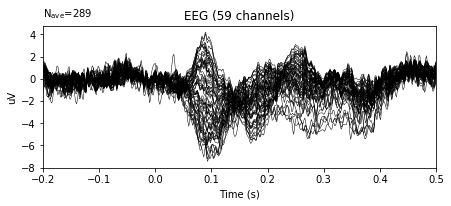

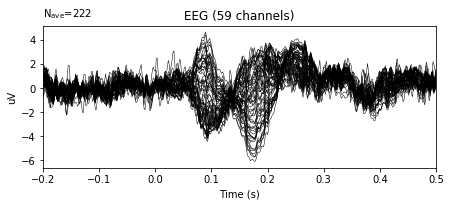

In [82]:
epochs2 = epochs.copy()
epochs2.drop(reject_idx)

epochs.average().pick_types(meg=False, eeg=True).plot();
epochs2.average().pick_types(meg=False, eeg=True).plot();


In [100]:
picks_eeg = mne.pick_types(
    epochs.info, meg=False, eeg=True, eog=False)

print(picks_eeg[:10])

[315 316 317 318 319 320 321 322 323 324]


In [101]:
x_eeg = epochs.get_data()[:, picks_eeg]

ptp_eeg = np.ptp(x_eeg, axis=-1)

ptp_eeg *= 1e6

Loading data for 289 events and 421 original time points ...


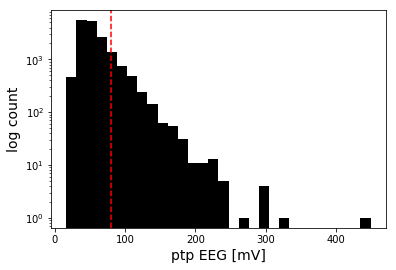

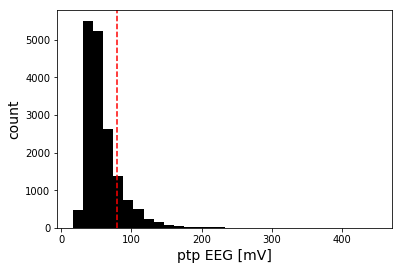

In [99]:
# import matplotlib.pyplot as plt
plt.figure()
plt.hist(ptp_eeg.ravel(), color='black', log=True, bins=30)
plt.ylabel('log count', fontdict={'size': 14})
plt.xlabel('ptp EEG [mV]', fontdict={'size': 14})
plt.axvline(80, color='red', linestyle='--');

plt.figure()
plt.hist(ptp_eeg.ravel(), color='black', log=False, bins=30)
plt.ylabel('count', fontdict={'size': 14})
plt.xlabel('ptp EEG [mV]', fontdict={'size': 14})
plt.axvline(80, color='red', linestyle='--')

In [102]:
rng = np.random.RandomState(42)

In [117]:
picks_subset = rng.choice(picks_eog, size=6, replace=False) - 305

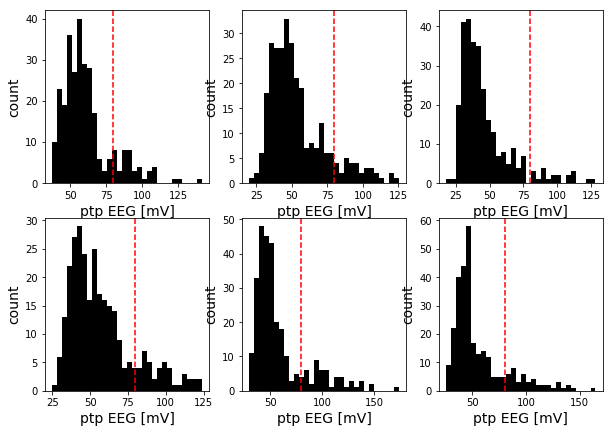

In [122]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes = axes.ravel()
for i_ax, ax in enumerate(axes):
    ax.hist(
        ptp_eeg[:, picks_subset[i_ax]],
        color='black', log=False, bins=30)
    ax.axvline(80, color='red', linestyle='--')
    ax.set_ylabel('count', fontdict={'size': 14})
    ax.set_xlabel('ptp EEG [mV]', fontdict={'size': 14})


In [125]:
bads = ['MEG 2443', 'EEG 053']
epochs.info['bads'] = []

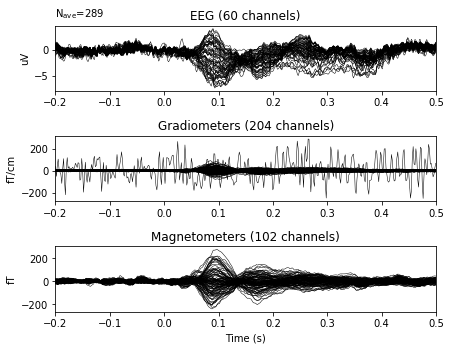

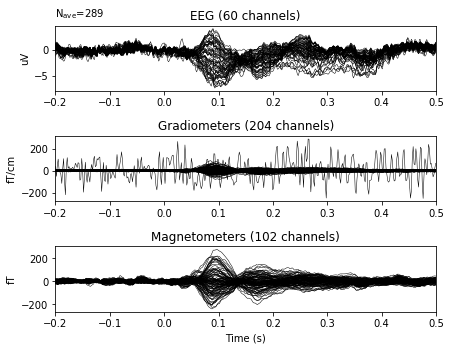

In [126]:
epochs.average().plot()

Loading data for 289 events and 421 original time points ...
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
    Computing dot products for 305 coils...
    Computing cross products for coils 305 x 1 coils...
    Preparing the mapping matrix...
    Truncating at 80/305 components to omit less than 0.0001 (9.4e-05)


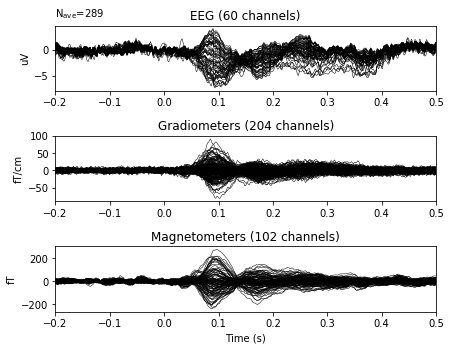

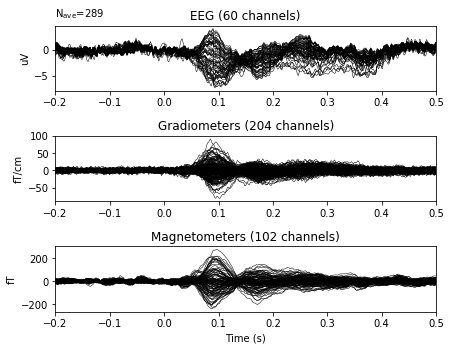

In [130]:
epochs.info['bads'] = ['MEG 2443', 'EEG 053']
epochs.load_data()
epochs.copy().interpolate_bads().average().plot()

# Automate this using Autoreject

http://autoreject.github.io/index.html

http://autoreject.github.io/auto_examples/plot_visualize_bad_epochs.html#sphx-glr-auto-examples-plot-visualize-bad-epochs-py

# Signal Space Projection (SSP)



In [141]:
# XXX arbitrary ad-hoc thresholds
reject_ssp = dict(
    grad=5000e-13, # T / m (gradiometers)
    mag=5e-12, # T (magnetometers)
    eeg=500e-6, # V (EEG channels)
    eog=2500e-6 # V (EOG channels)
)

projs, *_ = mne.preprocessing.compute_proj_eog(
    raw,
    reject=reject_ssp,
    n_grad=3, n_mag=3, n_eeg=3)

Including 3 SSP projectors from raw file
Running EOG SSP computation
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 8192 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 8192 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
Computing projector
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz
Filter length of 8192 samples (13.639 sec) selected
46 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 46 events and 241 original time points ...
0 bad epochs dropped
Adding projection: pl

In [137]:
epochs